# Mount Drive

In [1]:
from google.colab import drive
# Mount the Google Drive at /content/drive
drive.mount('/content/drive')

Mounted at /content/drive


# Vision Transformer (ViT)

In [2]:
!pip install torchinfo torch-lr-finder

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torchinfo import summary
from tqdm import tqdm

In [34]:
class Encoder(nn.Module):
    def __init__(self, embed_size = 768, num_heads = 3, dropout = 0.1):
        super().__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_size, 4*embed_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4*embed_size, embed_size),
            nn.Dropout(dropout)
        )
        self.dropout = dropout

    def forward(self, x):
        x = self.norm(x)
        x = x+self.attention(x, x, x)[0]
        x = self.norm2(x)
        x = x+self.feedforward(x)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, in_channels = 3, num_encoders = 6, embed_size = 768, img_size = (324, 324), patch_size = 16, num_classes = 10, num_heads = 4):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        num_tokens = (img_size[0]*img_size[1])//(patch_size**2)
        self.class_token = nn.Parameter(torch.randn((embed_size,)))
        self.patch_embedding = nn.Linear(in_channels*patch_size**2,embed_size)
        self.pos_embedding = nn.Parameter(torch.randn((num_tokens+1, embed_size)), requires_grad=True)
        self.encoders = nn.ModuleList([
            Encoder(embed_size=embed_size, num_heads=num_heads) for _ in range(num_encoders)
        ])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, num_classes)
        )
    def forward(self, x):
        batch_size, channel_size, height, width = x.shape

        # Check that the image dimensions are divisible by the patch size
        assert height % self.patch_size == 0 and width % self.patch_size == 0, \
            "Image dimensions must be divisible by the patch size."

        # Divide into patches
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)

        # Reshape patches to (batch_size, num_patches, patch_size * patch_size * channel_size)
        patches = patches.contiguous().view(batch_size, -1, channel_size * self.patch_size * self.patch_size)

        # Apply patch embedding
        x = self.patch_embedding(patches)

        # Add class token and positional embedding
        class_token = self.class_token.unsqueeze(0).repeat(batch_size, 1, 1)
        x = torch.cat([class_token, x], dim=1)
        x += self.pos_embedding

        # Pass through transformer encoders
        for encoder in self.encoders:
            x = encoder(x)

        # Classification token only
        return self.mlp_head(x[:, 0])



device = "cuda" if torch.cuda.is_available() else "cpu"
model = VisionTransformer(in_channels=1, img_size=(28, 28), patch_size=7, embed_size=64, num_heads=4, num_encoders=3).to(device)
summary(model, [2, 1, 28, 28])

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [2, 10]                   1,152
├─Linear: 1-1                            [2, 16, 64]               3,200
├─ModuleList: 1-2                        --                        --
│    └─Encoder: 2-1                      [2, 17, 64]               --
│    │    └─LayerNorm: 3-1               [2, 17, 64]               128
│    │    └─MultiheadAttention: 3-2      [2, 17, 64]               16,640
│    │    └─LayerNorm: 3-3               [2, 17, 64]               128
│    │    └─Sequential: 3-4              [2, 17, 64]               33,088
│    └─Encoder: 2-2                      [2, 17, 64]               --
│    │    └─LayerNorm: 3-5               [2, 17, 64]               128
│    │    └─MultiheadAttention: 3-6      [2, 17, 64]               16,640
│    │    └─LayerNorm: 3-7               [2, 17, 64]               128
│    │    └─Sequential: 3-8              [2, 17, 64]           

# 2. Data Transforms

In [35]:
import torch
from torch.utils.data import Dataset

class CustomTensorDataset(Dataset):
    def __init__(self, images_tensor, labels_tensor, transform = None):
        self.images_tensor = images_tensor
        self.labels_tensor = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.labels_tensor)

    def __getitem__(self, idx):
        image = self.images_tensor[idx]
        label = self.labels_tensor[idx]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

In [36]:
# Load the saved dataset
dataset = torch.load('/content/drive/MyDrive/TB_python/learning/learning/tb_digit.pt')
x_train, x_val, y_train, y_val = dataset['x_train'], dataset['x_val'], dataset['y_train'], dataset['y_val']

# Concatenate train and validation data along the batch dimension
x_combined = torch.cat((x_train, x_val), dim=0)

# Calculate mean and std across the combined dataset
mean = x_combined.mean()
std = x_combined.std()

print(f'mean: {mean.item()}, std: {std.item()}')

mean: 0.16871891915798187, std: 0.3569256365299225


<ipython-input-36-e7eae74724ae>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load('/content/drive/MyDrive/TB_python/learning/learning/tb_digit.pt')


In [37]:
print(x_train.shape)

torch.Size([12000, 1, 28, 28])


In [40]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Example transformations
data_transforms = transforms.Compose([
    transforms.Normalize(mean, std)         # Normalization with provided mean and std
])

# Using the custom dataset with transformations
train_set = CustomTensorDataset(images_tensor=x_train, labels_tensor=y_train, transform=data_transforms)
val_set = CustomTensorDataset(images_tensor=x_val, labels_tensor=y_val, transform=data_transforms)
train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
val_dl = DataLoader(val_set, batch_size=65, shuffle=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.03E-02


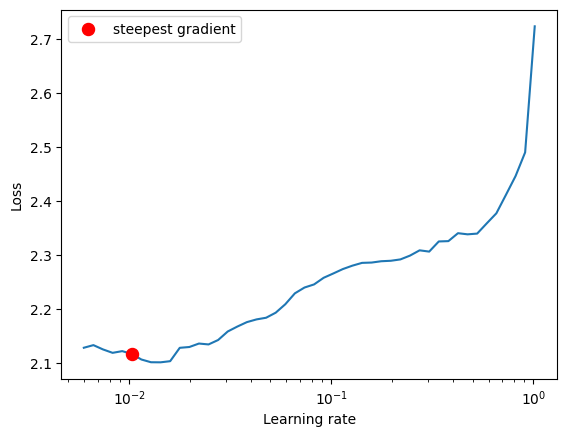

In [41]:
from torch_lr_finder import LRFinder

# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

# Initialize and run the LR finder
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, end_lr=100, num_iter=100)  # Perform the LR range test

# Plot the results to inspect the optimal learning rate
lr_finder.plot()

# Reset the model and optimizer to their initial state
lr_finder.reset()

# 5. Train ViT

In [43]:
# Set up model, optimizer, loss function, and scheduler
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VisionTransformer(in_channels=1, img_size=(28, 28), patch_size=7, embed_size=64, num_heads=4, num_encoders=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()
num_epochs = 50
patience = 5
best_val_loss = float("inf")
early_stop_counter = 0

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
    val_loss /= len(val_dl)

    # Print and save validation loss
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

    # Step the scheduler
    scheduler.step()



Epoch 1/50, Validation Loss: 2.13741431304554
Epoch 2/50, Validation Loss: 1.4990991496610566
Epoch 3/50, Validation Loss: 1.1540466767725108
Epoch 4/50, Validation Loss: 0.985766352547269
Epoch 5/50, Validation Loss: 0.8511445082955782
Epoch 6/50, Validation Loss: 0.7494409378867981
Epoch 7/50, Validation Loss: 0.6696291639218064
Epoch 8/50, Validation Loss: 0.6197418058824569
Epoch 9/50, Validation Loss: 0.5674274787306787
Epoch 10/50, Validation Loss: 0.5317972490405466
Epoch 11/50, Validation Loss: 0.49838952219750865
Epoch 12/50, Validation Loss: 0.48619580314465694
Epoch 13/50, Validation Loss: 0.47392906018406306
Epoch 14/50, Validation Loss: 0.4544432561384261
Epoch 15/50, Validation Loss: 0.4434676691322739
Epoch 16/50, Validation Loss: 0.42817933039172723
Epoch 17/50, Validation Loss: 0.42168587469381524
Epoch 18/50, Validation Loss: 0.4094266110493113
Epoch 19/50, Validation Loss: 0.4005509150691586
Epoch 20/50, Validation Loss: 0.38861043522997163
Epoch 21/50, Validation Lo

# Visualization : Validation set

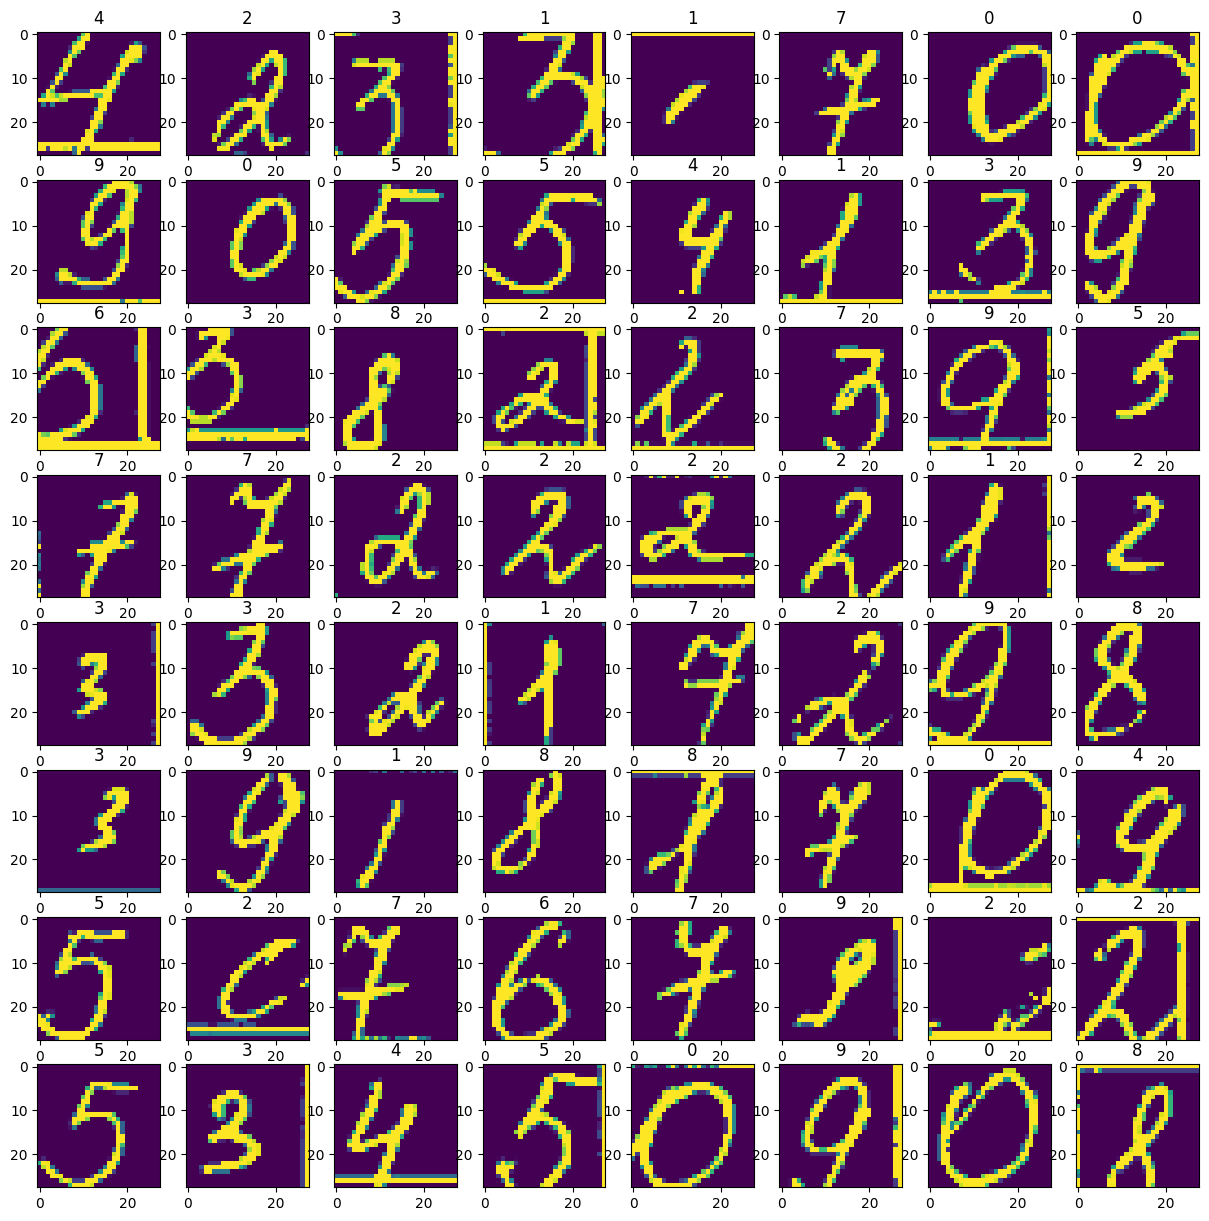

In [44]:
import matplotlib.pyplot as plt
with torch.no_grad():
    for image, _ in val_dl:
        image = image[:64].to(device)
        image = image.to(device)
        pred = model(image).argmax(dim=1).cpu().detach().numpy()
        image = image.cpu().detach().numpy()
        break
    fig, axes = plt.subplots(8, 8, figsize=(15, 15))
    for i in range(64):
        axes[i//8][i%8].set_title(pred[i])
        axes[i//8][i%8].imshow(image[i][0])